In [4]:
import pandas as pd
import numpy as np
import duckdb
from xgboost import XGBRegressor
import warnings
from tqdm.notebook import tqdm

modelling_conn = duckdb.connect('modelling_db')
modelling_conn.execute("SET memory_limit = '16GB'")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Testando múltiplos parâmetros

In [ ]:
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A
from modelling_utils import get_abt_estacoes_vizinhas,split_com_sem_vizinha,particao_por_estacao,feature_selection,undersample_zeros

percent_datetime_partitioning_split = 0.7

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

model_params = {}

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
resultados = []

for threshold in tqdm(np.arange(0.4, 0.91, 0.05), desc='Threshold Loop'):
    abt_com_vizinha, abt_sem_vizinha = split_com_sem_vizinha(abt_estacoes_vizinhas, threshold)

    # Particionar por estação
    treino_com, valid_com = particao_por_estacao(abt_com_vizinha, percent_datetime_partitioning_split)
    treino_sem, valid_sem = particao_por_estacao(abt_sem_vizinha, percent_datetime_partitioning_split)

    # Feature selection
    X_treino_com, y_treino_com = feature_selection(treino_com, featurelist_com_vizinha, target)
    X_valid_com, y_valid_com = feature_selection(valid_com, featurelist_com_vizinha, target)

    X_treino_sem, y_treino_sem = feature_selection(treino_sem, featurelist_sem_vizinha, target)
    X_valid_sem, y_valid_sem = feature_selection(valid_sem, featurelist_sem_vizinha, target)

    # Treinar modelos
    modelo_com = XGBRegressor(**model_params)
    modelo_sem = XGBRegressor(**model_params)

    modelo_com.fit(X_treino_com, y_treino_com)
    modelo_sem.fit(X_treino_sem, y_treino_sem)

    # Previsões
    y_pred_com = modelo_com.predict(X_valid_com)
    y_pred_sem = modelo_sem.predict(X_valid_sem)

    # Calcular métricas e salvar
    resultados.append({
        'threshold_prioridade': threshold,
        'tipo': 'com_vizinha',
        'precision': precision(y_valid_com, y_pred_com, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_valid_com, y_pred_com, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_valid_com, y_pred_com, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_valid_com, y_pred_com),
        'R2': R2_determinacao(y_valid_com, y_pred_com),
        'MAE': MAE(y_valid_com, y_pred_com),
        'PSC_A': PSC_A(y_valid_com, y_pred_com, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_valid_com, y_pred_com, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_valid_com, y_pred_com, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

    resultados.append({
        'threshold_prioridade': threshold,
        'tipo': 'sem_vizinha',
        'precision': precision(y_valid_sem, y_pred_sem, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_valid_sem, y_pred_sem, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_valid_sem, y_pred_sem, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_valid_sem, y_pred_sem),
        'R2': R2_determinacao(y_valid_sem, y_pred_sem),
        'MAE': MAE(y_valid_sem, y_pred_sem),
        'PSC_A': PSC_A(y_valid_sem, y_pred_sem, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_valid_sem, y_pred_sem, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_valid_sem, y_pred_sem, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

# Converter para DataFrame
df_resultados = pd.DataFrame(resultados)

Threshold Loop:   0%|          | 0/11 [00:00<?, ?it/s]

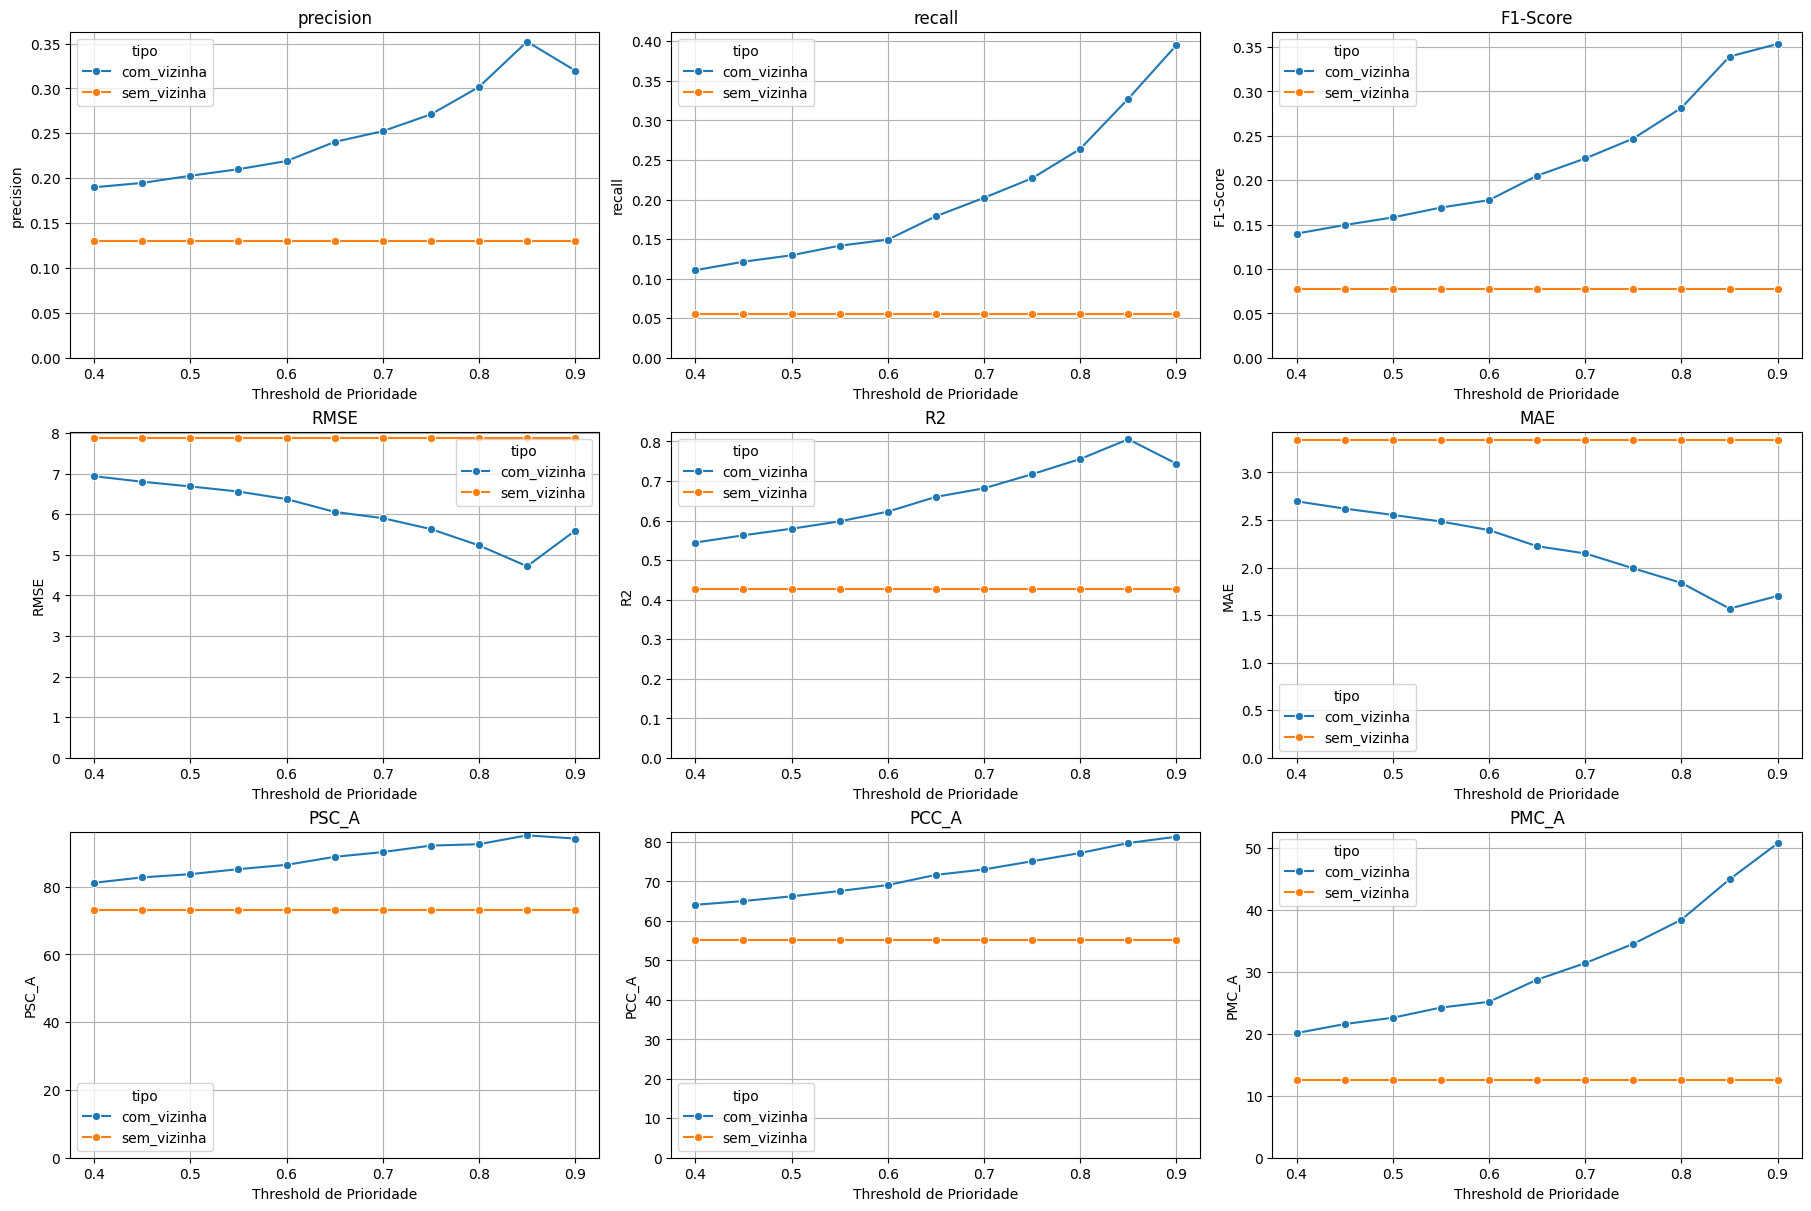

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de métricas que você quer plotar
metricas = ['precision', 'recall', 'F1-Score', 'RMSE', 'R2', 'MAE', 'PSC_A', 'PCC_A', 'PMC_A']

# Tamanho da figura (ajuste conforme necessário)
n_rows = (len(metricas) + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4 * n_rows), constrained_layout=True)

# Achatar os eixos para iterar facilmente
axes = axes.flatten()

for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.lineplot(
        data=df_resultados,
        x='threshold_prioridade',
        y=metrica,
        hue='tipo',
        marker='o',
        ax=ax
    )
    ax.set_title(metrica)
    ax.grid(True)
    ax.set_xlabel('Threshold de Prioridade')
    ax.set_ylabel(metrica)
    ax.set_ylim(0)

# Remover plots extras se sobrar eixo
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.savefig('metricas_por_threshold_de_prioridade_XGBoost.png')
plt.show()



In [ ]:
# PROXIMOS PASSOS:
# > Testar Random Forest
# > Analise de relevancia de variaveis (talvez PCA?)
# > OK Implementar métricas personalizadas
# > Testar undersampling
# > Testar oversampling (com smoteR)
# > Testar preenchimento de dados faltantes

# Testando apenas um Parâmetro

In [3]:
percent_datetime_partitioning_split = 0.7

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

model_params = {}

Model = XGBRegressor

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
treinamento, validacao = particao_por_estacao(abt_estacoes_vizinhas, percent_datetime_partitioning_split)
zr = 5
X_pre, y_pre = feature_selection(treinamento, featurelist_com_vizinha+['id_estacao','dt_medicao'], target)

final_abt = pd.DataFrame(X_pre)
final_abt['vl_precipitacao'] = y_pre

In [ ]:
final_abt.to_parquet('final_abt.parquet',index=False)

## Sem separação de com e sem vizinha

In [14]:
metricas = []

### Sem Undersampling

In [15]:
treinamento,validacao = particao_por_estacao(abt_estacoes_vizinhas,percent_datetime_partitioning_split)

X_treino,y_treino = feature_selection(treinamento,featurelist_com_vizinha,target)
X_validacao,y_validacao = feature_selection(validacao,featurelist_com_vizinha,target)

current_model = Model()
current_model.fit(X_treino, y_treino)
y_pred = current_model.predict(X_validacao)

metricas.append({
    'sampling':'Nenhum',
    'precision':precision(y_validacao,y_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'recall':recall(y_validacao,y_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'F1-Score':F_score(y_validacao,y_pred,beta=beta,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'RMSE':RMSE(y_validacao,y_pred),
    'R2':R2_determinacao(y_validacao,y_pred),
    'MAE':MAE(y_validacao,y_pred),
    'PSC_A':PSC_A(y_validacao,y_pred,erro=min_sem_chuva),
    'PCC_A':PCC_A(y_validacao,y_pred,erro=absolute_error_threshold),
    'PMC_A':PMC_A(y_validacao,y_pred,erro=absolute_error_threshold,chuva_minima=minimo_muita_chuva)
})

### Com UnderSampling

In [ ]:
zero_ratios = [1.0, 2.0, 3.0] 

treinamento, validacao = particao_por_estacao(abt_estacoes_vizinhas, percent_datetime_partitioning_split)
X_validacao, y_validacao = feature_selection(validacao, featurelist_com_vizinha, target)

for zr in zero_ratios:
    X_pre, y_pre = feature_selection(treinamento, featurelist_com_vizinha, target)
    X_treino, y_treino = undersample_zeros(X_pre, y_pre, zero_ratio=zr)

    current_model = Model()
    current_model.fit(X_treino, y_treino)
    y_pred = current_model.predict(X_validacao)

    metricas.append({
        'sampling': f'UnderSampling ratio={zr}',
        'precision': precision(y_validacao, y_pred, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_validacao, y_pred, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_validacao, y_pred, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_validacao, y_pred),
        'R2': R2_determinacao(y_validacao, y_pred),
        'MAE': MAE(y_validacao, y_pred),
        'PSC_A': PSC_A(y_validacao, y_pred, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_validacao, y_pred, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_validacao, y_pred, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


                  sampling  precision    recall  F1-Score      RMSE        R2  \
0                   Nenhum   0.186857  0.107983  0.136870  7.071591  0.537435   
1  UnderSampling ratio=1.0   0.182647  0.113860  0.140275  7.131620  0.529548   
2  UnderSampling ratio=1.5   0.186225  0.111288  0.139319  7.091786  0.534789   
3  UnderSampling ratio=2.0   0.185197  0.107023  0.135654  7.083417  0.535887   
4  UnderSampling ratio=3.0   0.186374  0.106698  0.135705  7.083933  0.535819   
5  UnderSampling ratio=5.0   0.186374  0.106698  0.135705  7.083933  0.535819   
6  UnderSampling ratio=1.0   0.182647  0.113860  0.140275  7.131620  0.529548   
7  UnderSampling ratio=2.0   0.185197  0.107023  0.135654  7.083417  0.535887   
8  UnderSampling ratio=3.0   0.186374  0.106698  0.135705  7.083933  0.535819   

        MAE      PSC_A      PCC_A      PMC_A  
0  2.812028  79.337319  62.431027  19.705128  
1  3.090018  70.832960  61.385373  21.040946  
2  2.930520  75.676065  61.930160  20.293783  
3

## Com separação de com e sem vizinha

In [ ]:
key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

In [ ]:
threshold_prioridade = 0.5
percent_datetime_partitioning_split = 0.7

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

# model_params = {
#     "tree_method": "hist",
#     "device": "cuda"
# }

model_params = {}

abt_com_vizinha,abt_sem_vizinha = split_com_sem_vizinha(abt_estacoes_vizinhas,threshold_prioridade)

treinamento_com_vizinha,validacao_com_vizinha = particao_por_estacao(abt_com_vizinha,percent_datetime_partitioning_split)
treinamento_sem_vizinha,validacao_sem_vizinha = particao_por_estacao(abt_sem_vizinha,percent_datetime_partitioning_split)

X_com_vizinha_treino,y_com_vizinha_treino = feature_selection(treinamento_com_vizinha,featurelist_com_vizinha,target)
X_sem_vizinha_treino,y_sem_vizinha_treino = feature_selection(treinamento_sem_vizinha,featurelist_sem_vizinha,target)
X_com_vizinha_validacao,y_com_vizinha_validacao = feature_selection(validacao_com_vizinha,featurelist_com_vizinha,target)
X_sem_vizinha_validacao,y_sem_vizinha_validacao = feature_selection(validacao_sem_vizinha,featurelist_sem_vizinha,target)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
Model = XGBRegressor    

model_com_vizinha = Model(**model_params)
model_sem_vizinha = Model(**model_params)

model_com_vizinha.fit(X_com_vizinha_treino, y_com_vizinha_treino)
model_sem_vizinha.fit(X_sem_vizinha_treino, y_sem_vizinha_treino)

y_com_vizinha_pred = model_com_vizinha.predict(X_com_vizinha_validacao)
y_sem_vizinha_pred = model_sem_vizinha.predict(X_sem_vizinha_validacao)

In [ ]:
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

metrics = {
    'precision':precision(y_com_vizinha_validacao,y_com_vizinha_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'recall':recall(y_com_vizinha_validacao,y_com_vizinha_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'F1-Score':F_score(y_com_vizinha_validacao,y_com_vizinha_pred,beta=beta,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'RMSE':RMSE(y_com_vizinha_validacao,y_com_vizinha_pred),
    'R2':R2_determinacao(y_com_vizinha_validacao,y_com_vizinha_pred),
    'MAE':MAE(y_com_vizinha_validacao,y_com_vizinha_pred),
    'PSC_A':PSC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=min_sem_chuva),
    'PCC_A':PCC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=absolute_error_threshold),
    'PMC_A':PMC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=absolute_error_threshold,chuva_minima=minimo_muita_chuva)
}

# MODELOS

In [4]:
from modelling_utils import get_abt_estacoes_vizinhas,split_com_sem_vizinha,particao_por_estacao,feature_selection,undersample_zeros,drop_estacoes_vizinhas,generate_X_y_train_test,train_model
from comparison_utils import compute_comparison_df
from xgboost import XGBRegressor
import pickle,os
import pandas as pd
import numpy as np
import duckdb
from xgboost import XGBRegressor
import warnings

modelling_conn = duckdb.connect('modelling_db')
modelling_conn.execute("SET memory_limit = '16GB'")
warnings.filterwarnings("ignore", category=DeprecationWarning)

relative_error_threshold = 0.2
absolute_error_threshold = 10
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20


abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn,abt_estacoes_vizinhas_table_name='abt_estacoes_3_vizinhas')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Modelo 1

In [19]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=1,
    usar_n_estacoes_vizinhas=0,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=False,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 2

In [23]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=2,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=False,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 3

In [24]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=3,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=False,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 4

In [25]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=4,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 5

In [26]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=5,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 6

In [2]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=6,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=2,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 7

In [3]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=7,
    usar_n_estacoes_vizinhas=1,
    zero_undersampling_ratio=5,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 8

In [7]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=8,
    usar_n_estacoes_vizinhas=2,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 9

In [10]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=9,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=1,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

## Modelo 10

In [5]:
model,comparison = train_model(
    abt_estacoes_vizinhas,
    Model=XGBRegressor,
    model_number=10,
    usar_n_estacoes_vizinhas=3,
    zero_undersampling_ratio=None,
    smote_oversampling=False,
    use_bi_model=True,
    threshold_prioridade=0.5,
    percent_datetime_partitioning_split=0.7,
    truncate_to_non_negative_target=True)

# COMPARAÇÕES

In [6]:
from comparison_utils import plot_model_metrics,import_model_and_comparison,compute_metrics,plot_metrica_heatmap,plot_metric_by_bin
import pandas as pd
import numpy as np

## Métricas Gerais

In [7]:
model_numbers = [1,2,3,4,5,6,7,8,9,10]
models,comparisons,metrics = {},{},{}
for model_number in model_numbers:
    model_path,comparison_path = f'models/model_{model_number}.pkl',f'comparisons/comparison_{model_number}.pkl'
    models[model_number],comparisons[model_number] = import_model_and_comparison(model_path,comparison_path)
    if type(models[model_number]) == dict:
        comparisons[model_number] = pd.concat(comparisons[model_number].values())

    comparisons[model_number]['model'] = f'model_{model_number}'
    metrics[model_number] = compute_metrics(comparisons[model_number]['y_test'],comparisons[model_number]['y_pred'])
metrics_df = pd.DataFrame.from_dict(metrics,orient='index').reset_index(names=['model_number'])

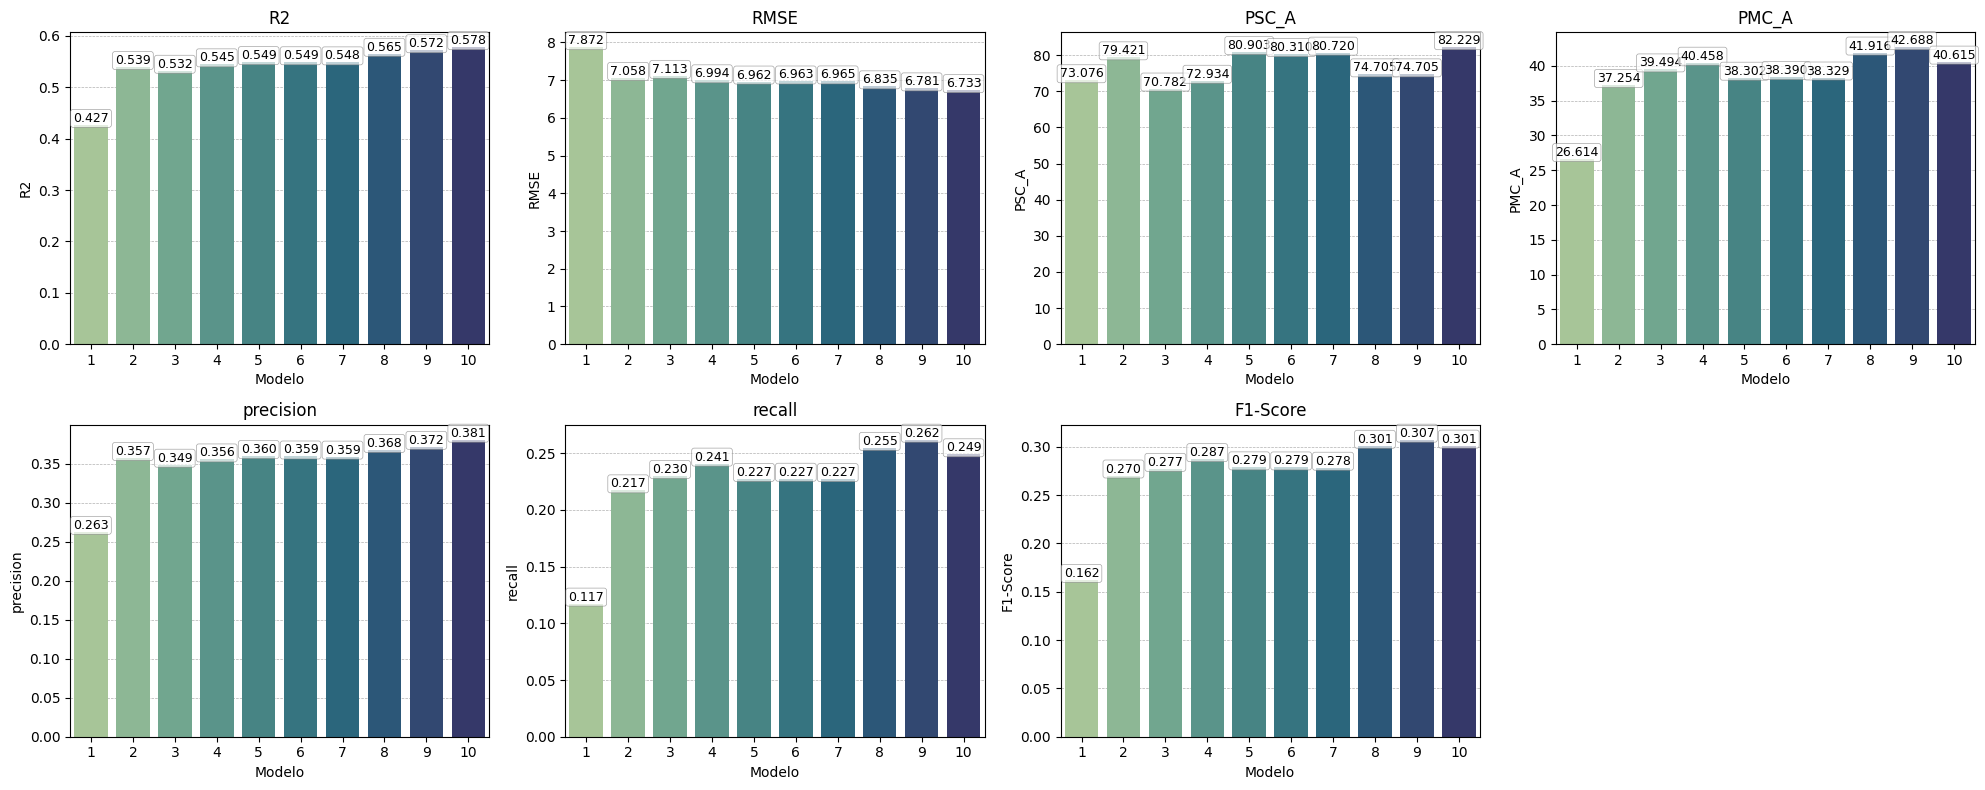

In [8]:
plot_model_metrics(metrics_df, ['R2', 'RMSE','PSC_A','PMC_A','precision','recall','F1-Score'])

## Análise por estações

In [9]:
estacoes = comparisons[1]['id_estacao'].unique()
dim_lat_lon = comparisons[1][['id_estacao','latitude','longitude']].drop_duplicates()

comparisons_estacoes = {
    model_number:{
        id_estacao:comparisons[model_number].loc[comparisons[model_number]['id_estacao']==id_estacao].copy() 
        for id_estacao in estacoes} 
    for model_number in comparisons.keys()}

metrics_estacoes = {
    model_number:{
        id_estacao:compute_metrics(comparisons_estacoes[model_number][id_estacao]['y_test'],comparisons_estacoes[model_number][id_estacao]['y_pred']) 
        for id_estacao in estacoes} 
    for model_number in comparisons.keys()}

dados = []
for model_number, estacoes_dict in metrics_estacoes.items():
    for id_estacao, metricas in estacoes_dict.items():
        linha = {"model_number": model_number, "id_estacao": id_estacao}
        linha.update(metricas)
        dados.append(linha)

df_metricas = pd.DataFrame(dados)
df_metricas = df_metricas.merge(dim_lat_lon,on='id_estacao',how='left')


C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Pa

c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\comparison_utils.py:121: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brasil_estados = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


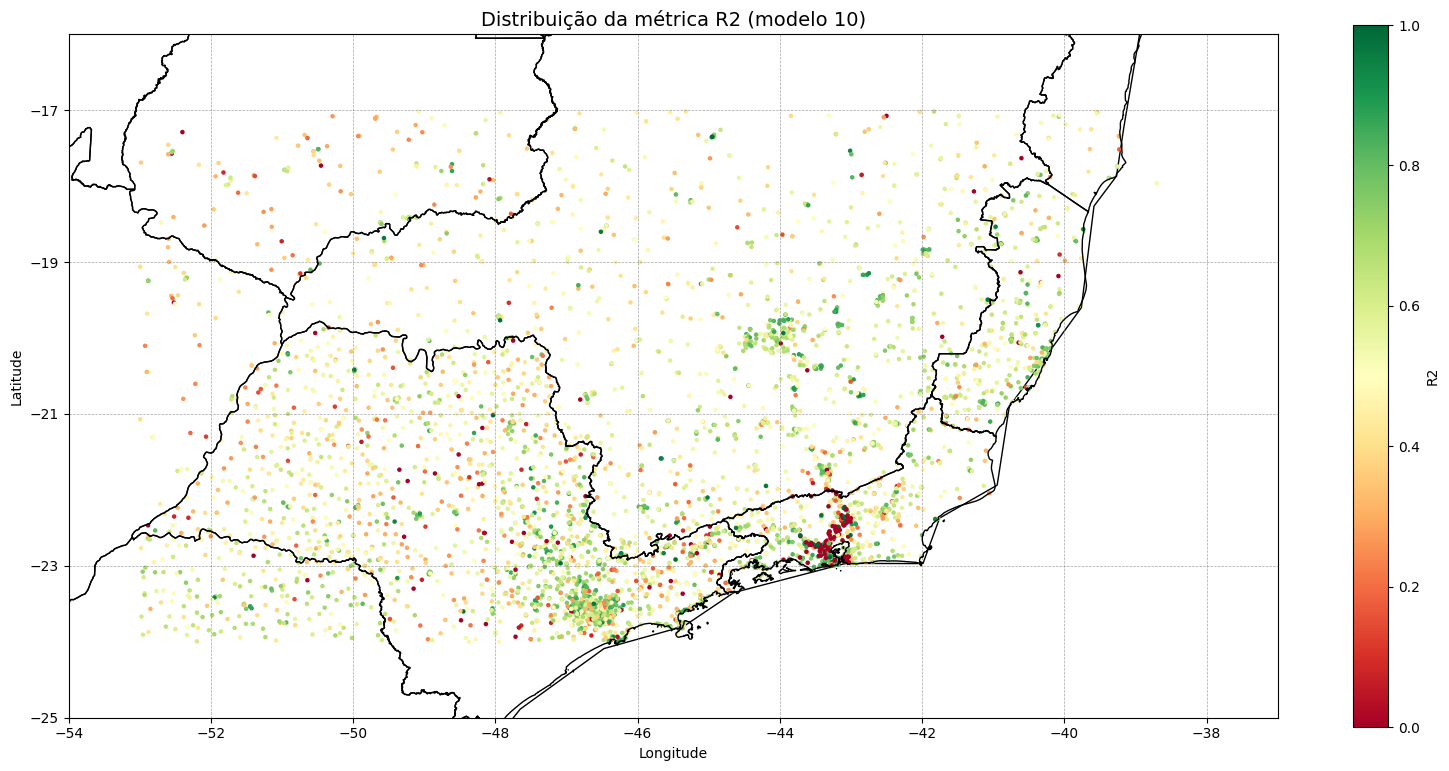

In [10]:
plot_metrica_heatmap(df_metricas, 'R2',model_number=10,figsize=(16,12),markersize=5)

# ANALISES INDIVIDUAIS

In [1]:
from comparison_utils import get_all_comparisons,get_metrics_per_station,plot_model_prediction_vs_observation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
model_numbers = [1,2,3,4,5,6,7]
comparison_df = get_all_comparisons(model_numbers)
count_medicoes_df = comparison_df.groupby(['model','id_estacao'],as_index=False).agg(count_medicoes=('y_test','count'))

metrics_per_station_df = get_metrics_per_station(comparison_df)
metrics_per_station_df = metrics_per_station_df.merge(count_medicoes_df,left_on=['model_number','id_estacao'],right_on=['model','id_estacao'],how='left')

C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Mateus Santos Rochas\AppData\Local\Pa

In [7]:
model_number = 5
min_count_medicoes = 100
metric = 'PMC_A'
ascending = True

metrics_per_station_df.loc[
    (metrics_per_station_df['model_number']==f'model_{model_number}')
    & (metrics_per_station_df['count_medicoes']>=min_count_medicoes)].sort_values(by=metric,ascending=ascending).head()

,model_number,id_estacao,precision,recall,F1-Score,RMSE,R2,MAE,PSC_A,PCC_A,PMC_A,latitude,longitude,model,count_medicoes
21891,model_5,926079,0.0,0.0,0.0,5.239179,-0.143039,2.707731,69.805195,85.877863,0.0,-22.6744,-47.2797,model_5,570
21953,model_5,926435,0.0,0.0,0.0,8.615268,0.169792,4.172802,65.432099,55.172414,0.0,-22.1667,-51.7667,model_5,110
20090,model_5,923856,0.0,0.0,0.0,3.922958,0.016703,1.273710,93.548387,76.470588,0.0,-21.3167,-47.3667,model_5,110
20575,model_5,926313,0.0,0.0,0.0,8.815400,0.460375,4.049699,70.121951,52.000000,0.0,-22.8333,-49.8167,model_5,214
21178,model_5,577561,0.0,0.0,0.0,6.507441,-0.057578,4.305391,82.608696,82.926829,0.0,-19.2673,-40.3314,model_5,146


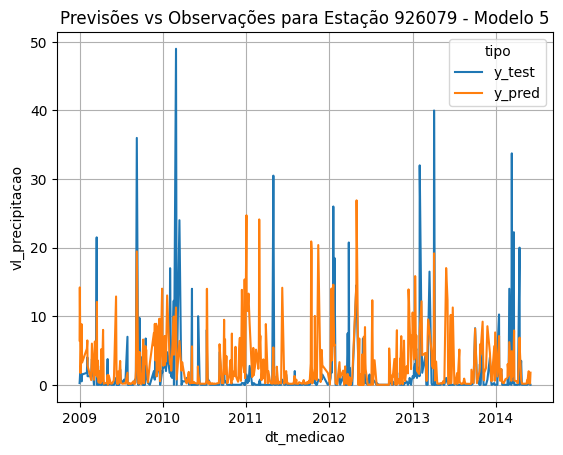

In [8]:
model_number = 5
id_estacao = 926079
plot_model_prediction_vs_observation(comparison_df, model_number=model_number, id_estacao=id_estacao)

In [10]:
from modelling_utils import get_abt_estacoes_vizinhas

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
abt_estacoes_vizinhas

,id_estacao,latitude,longitude,vl_declividade,vl_altitude,vl_distancia_oceano,vl_aspecto_relevo,dt_medicao,vl_precipitacao,vl_temperatura_maxima,...,vl_vento_maximo_2m_power,vl_vento_maximo_10m_power,vl_precipitacao_vizinha,vl_correlacao_vizinha,pct_intersecao_precipitacao_vizinha,vl_distancia_km_vizinha,estacao_vizinha_escolhida,vl_prioridade_vizinha,dt_medicao_mes,dt_medicao_ano
0,923901,-21.4333,-47.3333,1.74,595.0,287.12,247.83,2005-11-08,0.00000,NaN,...,2.654688,4.646875,0.000000,0.578020,97.120951,7.50,1.0,0.5527,11,2005
1,921373,-19.4158,-41.7297,12.38,420.0,165.79,299.42,2011-01-20,0.00000,NaN,...,2.660938,3.617188,0.000000,0.588478,93.812803,24.77,1.0,0.3532,1,2011
2,922797,-20.8500,-48.8500,3.47,534.0,419.54,3.95,2000-11-26,0.00000,NaN,...,2.393750,3.289062,0.000000,0.817498,100.000000,5.56,1.0,0.8123,11,2000
3,922073,-20.2964,-40.9339,8.77,815.0,57.84,274.84,2016-07-23,0.00000,NaN,...,3.995312,5.370312,0.000000,0.657976,98.972564,15.33,1.0,0.5746,7,2016
4,926460,-22.8981,-51.8881,1.03,498.0,421.43,100.01,2005-09-12,27.40000,NaN,...,3.157812,4.845313,36.200000,0.597978,98.415996,13.40,1.0,0.5404,9,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18194961,924569,-22.1061,-41.4711,0.30,10.0,11.01,168.69,2001-05-09,0.00000,NaN,...,6.085938,7.054688,0.000000,0.278218,100.000000,29.91,1.0,0.1397,5,2001
18194962,923682,-21.4203,-46.9628,1.25,581.0,277.84,334.65,2022-08-07,0.00000,NaN,...,2.435938,4.234375,0.000000,0.447699,96.758931,12.93,1.0,0.4011,8,2022
18194963,577228,-23.0936,-46.9718,0.17,0.0,105.20,30.96,2018-07-16,0.00000,NaN,...,3.087500,4.393750,0.000000,0.755313,99.882145,5.02,1.0,0.7509,7,2018
18194964,577228,-23.0936,-46.9718,0.17,0.0,105.20,30.96,2018-06-12,0.98577,NaN,...,4.981250,7.214062,4.138237,0.755313,99.882145,5.02,1.0,0.7509,6,2018
